# Homework 2 Yalin Liao

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import trange

In [2]:
train_X = pd.read_csv("train_X.csv",header=None)

In [3]:
train_X.head()

,0,1,2
0,3,1,1
1,7,1,1
2,8,1,1
3,10,1,1
4,13,1,1


In [4]:
print(train_X.shape)

(170604, 3)


In [5]:
train_X = train_X.to_numpy()
print(train_X.shape)
print(train_X[:,0].max())
print(train_X[:,1].min())

(170604, 3)
8124
1


### Express data in sparse matrix

In [6]:
D = 112
N_train = 8124
X_train = np.zeros((N_train, D))
for i in range(train_X.shape[0]):
    r = train_X[i,0]-1
    c = train_X[i,1]-1
    X_train[r,c] = 1

## Do same operations on test data

In [7]:
test_X = pd.read_csv("test_X.csv",header=None)

In [8]:
test_X.head()

,0,1,2
0,10,1,1
1,39,1,1
2,44,1,1
3,52,1,1
4,59,1,1


In [9]:
print(test_X.shape)

(4000, 3)


In [10]:
test_X = test_X.to_numpy()
print(test_X.shape)
print(test_X[:,0].max())
print(test_X[:,0].min())

(4000, 3)
200
1


In [11]:
N_test = 200
X_test = np.zeros((N_test, D))
for i in range(test_X.shape[0]):
    r = test_X[i,0]-1
    c = test_X[i,1]-1
    X_test[r,c] = 1

In [12]:
print(X_train.shape)
print(X_test.shape)

(8124, 112)
(200, 112)


In [13]:
train_Y = pd.read_csv("train_Y.csv",header=None)
train_Y.head()

,0
0,-1
1,1
2,1
3,-1
4,1


In [14]:
Y_train = train_Y.to_numpy()
print(Y_train.shape)
# Y_train

(8124, 1)


In [15]:
test_Y = pd.read_csv("test_Y.csv",header=None)
test_Y.head()

,0
0,-1
1,1
2,-1
3,-1
4,1


In [16]:
Y_test = test_Y.to_numpy()
print(Y_test.shape)
# Y_test

(200, 1)


#### 1) 
Eating a poisonous mushroom may cause more adverse effects than not eating an edible one.

Since limited linear classifiers, we choose logistic regression. The binary cross-entropy loss for the point $(x_i,y_i)$ is
$$J(w)=\begin{cases}-\ln(\sigma(w^Tx_i))&y_i=1\\-\ln(1-\sigma(w^Tx_i))&y_i=-1\end{cases}$$
where $\sigma(x)=\frac{e^x}{1+e^x}$. Since eating a poisonous mushroom may cause more adverse effects than not eating an edible one, we should penelize more for samples $x_i$ assoicated with $y_i=-1$. In this way, our trained model is less likely to predict the poisonous mushroom as edible one. For example, We could set the loss weigh as follows $$w_{loss}=\begin{cases}1&y_i=1\\1.2&y_i=-1\end{cases}$$

We convert the label $-1$ to $0$ for logistic regression using cross entropy loss.

In [17]:
Y_train = 0.5*(Y_train+1)
Y_test = 0.5*(Y_test+1)

In [18]:
print(Y_train[0:5])
print(Y_test[0:5])

[[0.]
 [1.]
 [1.]
 [0.]
 [1.]]
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]]


We train logistical regression by PyTorch. So all data are transformed into torch tensors.

In [19]:
import torch
from torch import nn
from matplotlib import pyplot as plt
torch.manual_seed(0)

In [20]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()
X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).float()

In [21]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

torch.Size([8124, 112])
torch.Size([8124, 1])
torch.Size([200, 112])
torch.Size([200, 1])


In [22]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
print(N_train)
print(N_test)

8124
200


First, we train a logistic regression (The sample loss is not weighted)

In [23]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear=nn.Linear(input_size,1)
        
    def forward(self,input):
        output=torch.sigmoid(self.linear(input))
        return output

In [24]:
input_size = X_train.shape[1]
print(input_size)

112


In [25]:
model = LogisticRegression(input_size)
print(model)

LogisticRegression(
  (linear): Linear(in_features=112, out_features=1, bias=True)
)


In [26]:
y0=model(X_train)
print(y0.shape)

torch.Size([8124, 1])


choose binary cross entropy loss and adam optimizer

In [27]:
bce=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())

start to train model

In [28]:
history={'train_loss':[],'test_loss':[]}
for epoch in trange(10000):
    pred_train = model(X_train)
    train_loss = bce(pred_train,Y_train)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    history['train_loss'].append(train_loss.item())
    
    pred_test = model(X_test)
    test_loss = bce(pred_test,Y_test)
    history['test_loss'].append(test_loss.item())

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 983.35it/s]


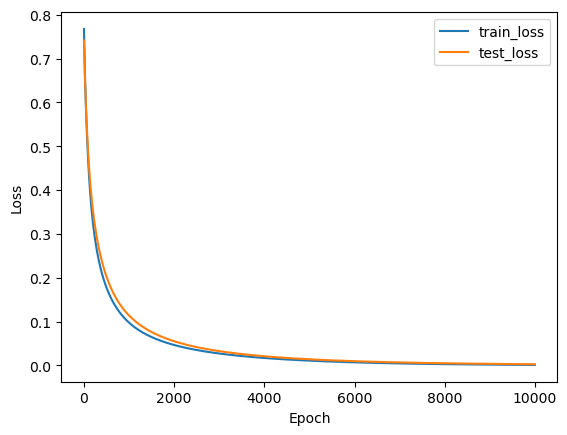

In [29]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
print(history["train_loss"][-5:-1])
print(history["test_loss"][-5:-1])

[0.0013091425644233823, 0.0013085909886285663, 0.001308038248680532, 0.0013074864400550723]
[0.002824608003720641, 0.0028238340746611357, 0.0028230559546500444, 0.0028222885448485613]


In [31]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.2785, -3.9878,  0.0435,  0.0107,  3.1227,  0.0307,  0.7371, -4.4742,
         -0.9852, -0.1602, -2.6678,  3.8086,  0.8101, -0.0277,  1.0694, -2.1462,
          3.3193,  3.3337, -0.7956,  0.7891,  0.8481, -0.3276,  4.5699, -5.4178,
         -3.0410,  4.5926, -1.7318,  2.7986, -4.4638, -2.2280, -2.2381,  1.1159,
         -0.1078, -1.4519,  0.9894,  1.9829, -2.6588, -1.9310,  2.3915,  0.8162,
          0.2528,  1.6085,  1.3810,  1.0346,  1.1116, -2.8901,  0.9990,  0.9741,
          0.6906, -0.3122,  0.3578,  0.6819, -1.3685,  1.0569,  2.5617,  1.6143,
         -0.7015,  0.4906, -1.9685, -1.5507, -1.7746,  1.9808,  1.4196, -1.4104,
          1.2510, -0.1879, -0.0477, -2.6688, -1.2508, -1.7266,  1.7736,  1.3765,
          0.1416,  1.2774, -0.1902, -0.3464, -3.4405,  0.1068,  1.2005,  1.1468,
         -0.1697, -2.6068, -1.7455, -0.8248,  1.3510, -0.1643,  6.3331, -2.0030,
         -1.7810,  0.0254,  1.2528, -2.5802,  2.3658,  2.4816,  1.1520, -6.4590,
     

Now we calculate the classification error.

In [32]:
print(Y_test[0])
print(pred_test[0])

tensor([0.])
tensor([0.0002], grad_fn=<SelectBackward0>)


That is, $p(y_1=1|x_1)=0.0012<0.5$ and thus $\hat{y}_1=0$ while $y_1=0$.

### Train error, 
case 1, $y_i=1$ but $\hat{y}_i=0$ (edible but prediction is poisonous)

In [33]:
sum(1 for i in range(Y_train.shape[0]) if pred_train[i]<0.5 and Y_train[i]==1.)

0

No edible mushrooms are classified as poisonous in the training dataset.

We more care about case 2, $y_i=0$ but $\hat{y}_i=1$(poisonous but predicted as edible).

In [34]:
sum(1 for i in range(Y_train.shape[0]) if pred_train[i]>=0.5 and Y_train[i]==0.)

0

No poisonus mushrooms are classified as edible in the training dataset.

Let see model performance on test dataset.

In [35]:
sum(1 for i in range(Y_test.shape[0]) if pred_test[i]<0.5 and Y_test[i]==1.)

0

No edible mushrooms are classified as poisonous.

In [36]:
sum(1 for i in range(Y_test.shape[0]) if pred_test[i]>=0.5 and Y_test[i]==0.)

0

No poisonous mushrooms are classified as edible.

Although there is no error in both training and test dataset, we still try to penalize more on poisonous mushrooms such that our model is more robust in terms of not predict poisonous mushrooms as edible.

Display model performance via comfusion matrix

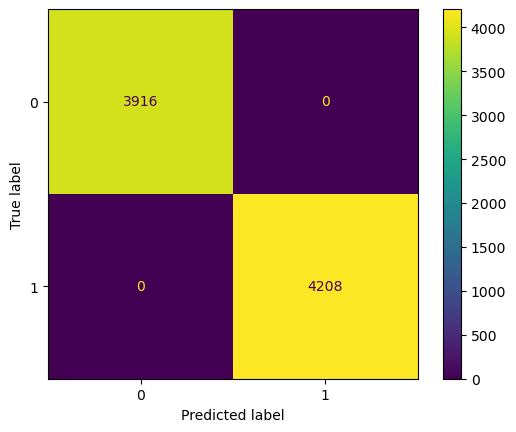

In [37]:
pred_train_01 = torch.where(pred_train>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_train, pred_train_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

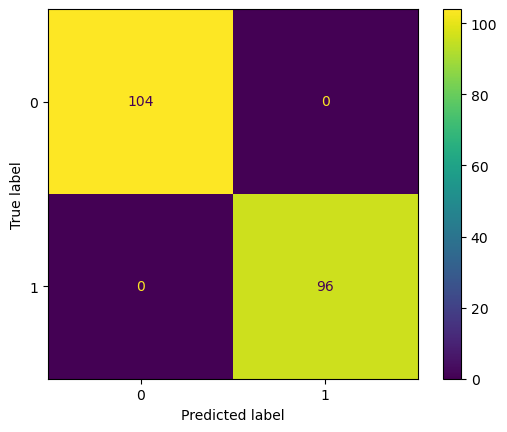

In [38]:
pred_test_01 = torch.where(pred_test>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_test, pred_test_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

In [39]:
model = LogisticRegression(input_size)
print(model)

LogisticRegression(
  (linear): Linear(in_features=112, out_features=1, bias=True)
)


In [40]:
bce=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())

In [41]:
# split training data
X0_train = torch.stack([X_train[i,:] for i in range(N_train) if Y_train[i]==0.0])
Y0_train = torch.zeros((X0_train.shape[0],1))
X1_train = torch.stack([X_train[i,:] for i in range(N_train) if Y_train[i]==1.0])
Y1_train = torch.ones((X1_train.shape[0],1))
print(X0_train.shape)
print(Y0_train.shape)
print(X1_train.shape)
print(Y1_train.shape)

torch.Size([3916, 112])
torch.Size([3916, 1])
torch.Size([4208, 112])
torch.Size([4208, 1])


In [42]:
history={'train_loss':[],'test_loss':[]}
for epoch in trange(10000):
    pred0_train = model(X0_train)
    loss0 = bce(pred0_train,Y0_train)
    pred1_train = model(X1_train)
    loss1 = bce(pred1_train,Y1_train)
    train_loss = 1.2*loss0 + loss1
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    history['train_loss'].append(train_loss.item())
    
    pred_test = model(X_test)
    test_loss = bce(pred_test,Y_test)
    history['test_loss'].append(test_loss.item())

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 801.86it/s]


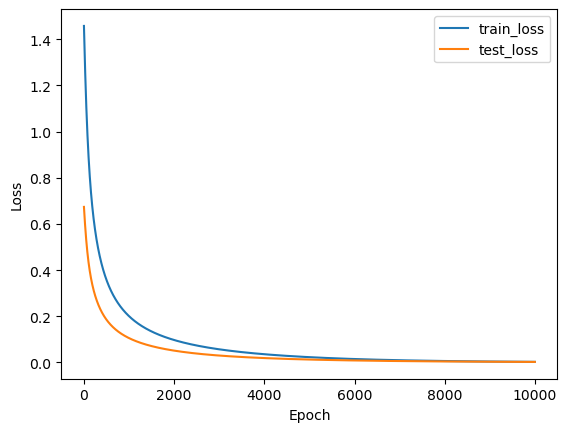

In [43]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
sum(1 for i in range(Y1_train.shape[0]) if pred1_train[i]<0.5)

0

No edible mushrooms are classified as poisonous in the training dataset.

In [45]:
sum(1 for i in range(Y0_train.shape[0]) if pred0_train[i]>=0.5)

0

No poisonous mushrooms are predicted as edible in the training dataset.

In [46]:
sum(1 for i in range(Y_test.shape[0]) if pred_test[i]<0.5 and Y_test[i]==1.)

0

No edible mushrooms are classified as poisonous in the test dataset.

In [47]:
sum(1 for i in range(Y_test.shape[0]) if pred_test[i]>=0.5 and Y_test[i]==0.)

0

No poisonous mushrooms are classified as edible.

Display model performance via confusion matrix

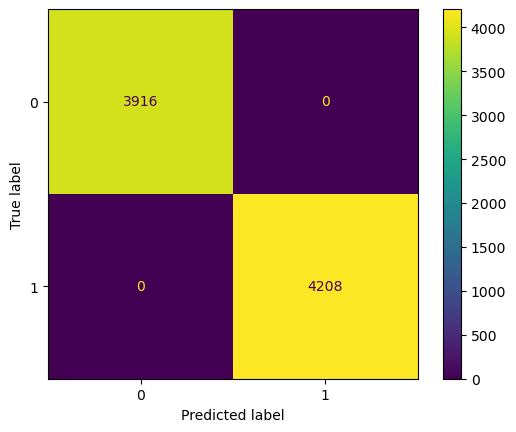

In [48]:
pred_train = model(X_train)
pred_train_01 = torch.where(pred_train>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_train, pred_train_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

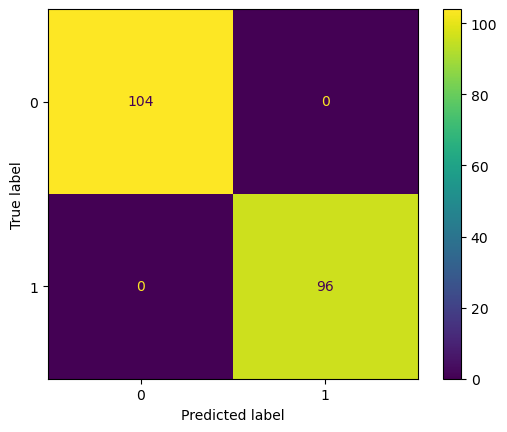

In [49]:
pred_test_01 = torch.where(pred_test>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_test, pred_test_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

### 2) 
The first classification model should be linear. Additionally, use Lasso ($l_1$ regularization) to perform feature selection.  (For a bonus you can implement BoLasso.) Theses leaves different choices of
loss/optimization: State whether you will use a $l_1$-regularized support vector machine (primal or
dual), $l_1$-regularized logistic regression, or if you will treat the labels as targets and use $l_1$- regularized least squares. Justify your choice and explain the difference between these choices.

Since the output domain is $\{1,-1\}$ or $\{1,0\}$, limiting the model output in interval $[0,1]$ is helpful to achieve better performance and so the sigmoid functions follows the linear layer. If the mean square loss is selected, the optmization problem is nonconvex and we may get a local minimum if using gradient-based approach to solve the problem. Choosing cross-entropy as loss leads to a convex problem. So cross-entropy loss logistic regression model is a wise choice. To make the model robust to outliers or noises, we consider the $l_1$ regulerization term. Since there are so many training data points, using SVM is not computationally efficient. Therefore, we do logistic regression + Lasso.

In [50]:
model = LogisticRegression(input_size)
print(model)

LogisticRegression(
  (linear): Linear(in_features=112, out_features=1, bias=True)
)


In [51]:
bce=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())

In [52]:
history={'train_loss':[],'test_loss':[]}
for epoch in trange(10000):
    pred_train = model(X_train)
    loss = bce(pred_train,Y_train)
    l1_norm = sum(torch.abs(p).sum() for p in model.parameters())
    train_loss = loss + 0.001*l1_norm
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    history['train_loss'].append(train_loss.item())
    
    pred_test = model(X_test)
    test_loss = bce(pred_test,Y_test)
    history['test_loss'].append(test_loss.item())

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 826.46it/s]


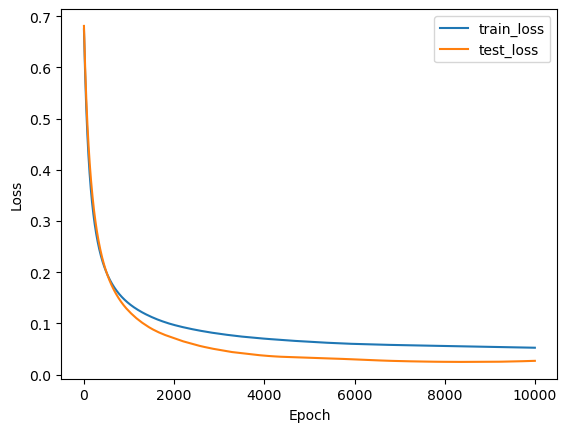

In [53]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
sum(1 for i in range(N_train) if Y_train[i]==1. and pred_train[i]<0.5)
+sum(1 for i in range(N_train) if Y_train[i]==0. and pred_train[i]>=0.5)

16

In the training dataset, there are $16$ samples are misclassified.

In [55]:
sum(1 for i in range(N_test) if Y_test[i]==1. and pred_test[i]<0.5)
+sum(1 for i in range(N_test) if Y_test[i]==0. and pred_test[i]>=0.5)

0

No data points are missclassified in test dataset.

In [56]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-3.8491e-04, -2.7308e-04, -1.7899e-04, -6.4532e-05, -6.6497e-05,
         -3.3409e-05,  4.0982e-01,  1.2665e-04,  1.9209e-04, -2.0790e-04,
         -8.6421e-04,  2.6147e-04, -6.0872e-05,  4.7565e-05,  6.9631e-05,
          5.8501e-05, -4.0166e-05,  4.2223e-04, -2.3814e-04, -3.3200e-05,
         -2.7503e-05,  1.2966e-04,  3.6374e+00, -1.8268e+00, -4.0759e+00,
          3.6383e+00, -1.3049e-04,  4.3786e+00, -1.1748e+00, -2.7874e-05,
         -2.9780e-04,  4.0353e-04, -4.3374e-04, -1.0108e+00,  7.6181e-04,
          9.7991e-01, -2.2437e+00, -1.1990e+00,  4.5678e-04, -2.4320e-04,
         -3.6738e-04,  3.2409e-04,  2.5011e-04,  5.3764e-05,  9.2804e-05,
         -6.6852e-04, -4.0117e-05,  9.0588e-05, -3.4929e-04, -1.3018e-04,
          6.1330e-05,  2.2901e-04, -1.6289e+00,  5.8131e-01, -2.2322e-04,
          6.3845e-04,  1.2774e-04,  5.1682e-04, -5.6647e-01, -2.0406e-04,
         -2.5043e-04,  3.4662e-05, -1.0719e-04,  1.8276e-04, -1.7887e-04,
          1.365

Compared to logistic regression, many parameters are in scale $10^{-5}$. We think they are irrelevant features.

Display model performance via confusion matrix

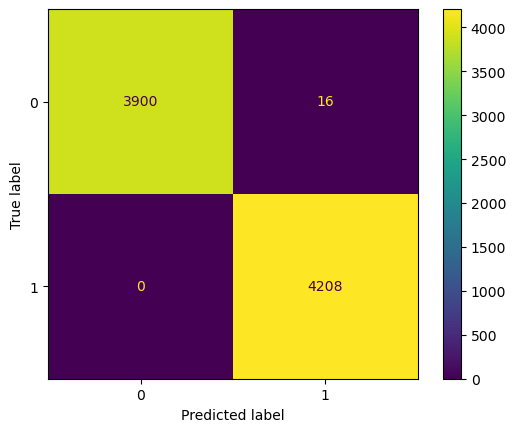

In [57]:
pred_train_01 = torch.where(pred_train>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_train, pred_train_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

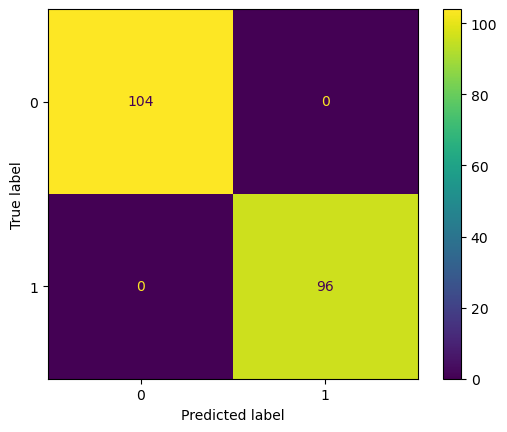

In [58]:
pred_test_01 = torch.where(pred_test>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_test, pred_test_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

### 3) 
You may note that the data covariance is singular, which may induce problems depending on the choice of the the linear classifier. You have options based on regularization such as additional $l_2$
regularization or elastic-net, adding small amount of noise, or principal component analysis. Which
do you choose and why?

Since this is a binary classification task, the best choice among linear models are the cross-entropy loss logistic regression. As stated earlier, the cross-entropy loss logistic regression is a convex problem with respect to its parameters $w$ and $b$. If the data covariance is singular, the problem is not strongly convex. After adding $l_2$ regularization, the problem is strongly convex and thus the solution is unique.

In [59]:
model = LogisticRegression(input_size)
print(model)

LogisticRegression(
  (linear): Linear(in_features=112, out_features=1, bias=True)
)


In [60]:
bce=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())

In [61]:
history={'train_loss':[],'test_loss':[]}
for epoch in trange(10000):
    pred_train = model(X_train)
    loss = bce(pred_train,Y_train)
    l2_norm = sum(torch.linalg.norm(p) for p in model.parameters())
    train_loss = loss + 0.001*l2_norm
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    history['train_loss'].append(train_loss.item())
    
    pred_test = model(X_test)
    test_loss = bce(pred_test,Y_test)
    history['test_loss'].append(test_loss.item())

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 805.05it/s]


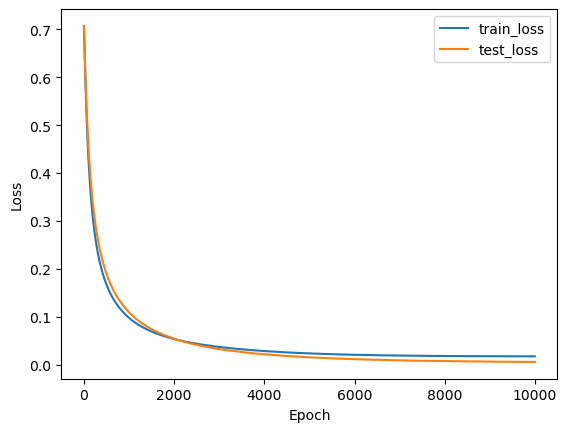

In [62]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
sum(1 for i in range(N_train) if Y_train[i]==1. and pred_train[i]<0.5)
+sum(1 for i in range(N_train) if Y_train[i]==0. and pred_train[i]>=0.5)

0

In [64]:
sum(1 for i in range(N_test) if Y_test[i]==1. and pred_test[i]<0.5)
+sum(1 for i in range(N_test) if Y_test[i]==0. and pred_test[i]>=0.5)

0

There are no misclassfied samples in training and testing dataset.

In [65]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.2860, -0.5916, -0.0178,  0.0263,  0.6955,  0.0564,  0.7951, -0.8666,
         -0.2266,  0.1617, -1.2133,  0.8864,  0.0729, -0.1560,  0.4789, -1.1703,
          0.6067,  0.6069, -0.5905,  0.2964,  0.5443, -0.5876,  3.5981, -4.7275,
         -2.8737,  3.6129, -0.4709,  3.3105, -3.0993, -1.1246, -1.1244,  0.2717,
         -0.3990, -1.1400,  1.0375,  2.1100, -2.2489, -1.6192,  0.7376,  0.0868,
         -0.0815,  0.6544,  0.7451,  0.1960,  0.4818, -0.8213,  0.3369,  0.2971,
         -0.1026, -0.2940,  0.1639,  0.5336, -1.3306,  1.1321, -0.1314,  1.3711,
         -0.4545,  0.3453, -1.2662, -0.5157, -0.4709,  0.6596,  0.6354, -0.2980,
          0.5971, -0.2779,  0.0564, -0.4355, -0.4201, -0.4708,  0.6047,  0.5971,
          0.3792,  0.5971, -0.2992, -0.1233, -0.9311, -0.1394,  0.2886,  0.2884,
         -0.2836, -0.4356, -0.4707, -0.1766,  0.5697, -0.2053,  3.3767, -1.5219,
         -0.4707, -0.1762,  0.1815, -2.0234,  2.0253,  2.1621,  0.1816, -5.1239,
     

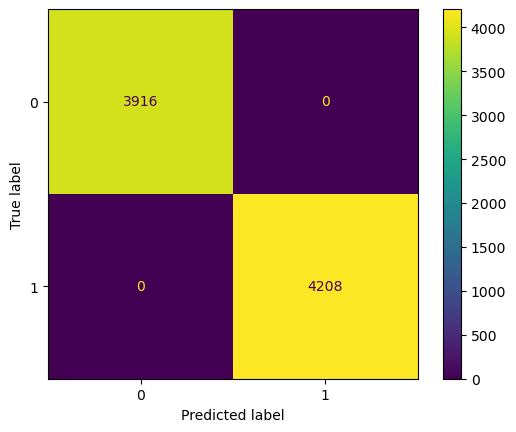

In [66]:
pred_train_01 = torch.where(pred_train>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_train, pred_train_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

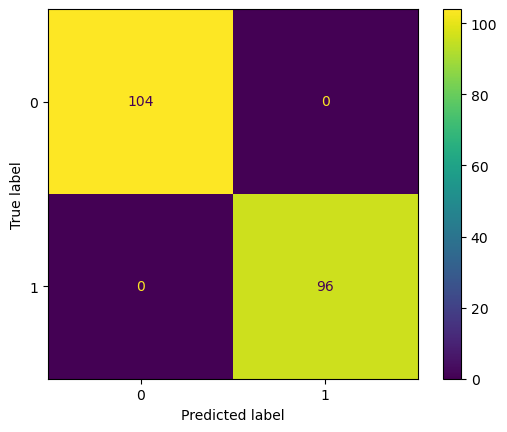

In [67]:
pred_test_01 = torch.where(pred_test>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_test, pred_test_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

### 4)
After identifying the support using a shrinkage, you should optimize the linear classifier on the
subset of features without regularization. Please report the size of the support for relevant features. List the selected feature (names or indices) along with their coefficients.

feature selection using $l_1$ regularization as in 2).

In [68]:
model = LogisticRegression(input_size)
bce=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())
history={'train_loss':[],'test_loss':[]}
for epoch in trange(10000):
    pred_train = model(X_train)
    loss = bce(pred_train,Y_train)
    l1_norm = sum(torch.abs(p).sum() for p in model.parameters())
    train_loss = loss + 0.001*l1_norm
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    history['train_loss'].append(train_loss.item())
    
    pred_test = model(X_test)
    test_loss = bce(pred_test,Y_test)
    history['test_loss'].append(test_loss.item())

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 806.45it/s]


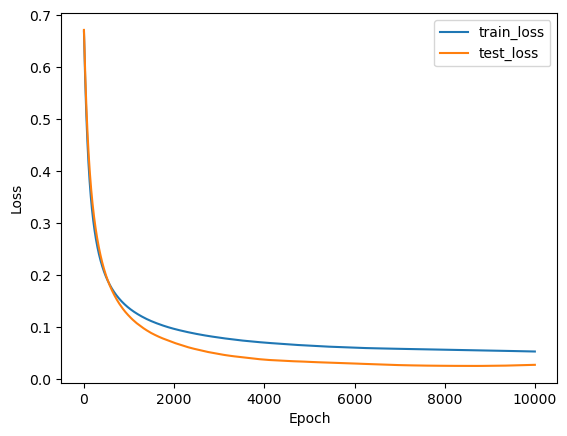

In [69]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-1.7819e-04, -1.3297e-05,  1.8326e-04, -7.7308e-05, -4.5888e-05,
         -3.2716e-05,  4.0602e-01, -4.2890e-04, -1.9502e-04, -1.3282e-04,
         -1.1458e-04,  6.5392e-05, -8.5327e-05,  2.0291e-04,  4.9758e-04,
         -5.1768e-04,  3.4923e-04,  3.2436e-04, -5.6144e-04, -2.0552e-04,
         -2.6758e-04, -9.4092e-05,  3.6977e+00, -1.7536e+00, -4.0091e+00,
          3.6986e+00, -1.0063e-04,  4.4321e+00, -1.1319e+00,  1.1816e-04,
         -1.3137e-04,  1.1035e-04,  1.5495e-04, -9.9546e-01,  1.6144e-04,
          8.7016e-01, -2.3470e+00, -1.1695e+00, -5.0375e-05, -1.9623e-04,
         -1.1346e-04,  5.6909e-05,  6.9397e-04, -3.4034e-04, -4.9400e-05,
          9.9930e-05, -6.2839e-05, -8.5974e-05, -2.2581e-05, -9.5703e-05,
          2.5213e-04,  1.8223e-04, -1.5922e+00,  6.1201e-01, -4.6050e-04,
          3.5535e-03, -1.3598e-04,  3.8088e-04, -5.7279e-01,  4.1665e-06,
          1.8444e-04, -1.6434e-04, -1.7098e-05,  3.0100e-05,  6.7951e-06,
         -5.960

We think that features, which have model parameters in scale of $10^{-2}$ or smaller, are irrelevant features. The rest are relevant features.

In [71]:
w = model.linear.weight.data.view(-1)
w

tensor([-1.7819e-04, -1.3297e-05,  1.8326e-04, -7.7308e-05, -4.5888e-05,
        -3.2716e-05,  4.0602e-01, -4.2890e-04, -1.9502e-04, -1.3282e-04,
        -1.1458e-04,  6.5392e-05, -8.5327e-05,  2.0291e-04,  4.9758e-04,
        -5.1768e-04,  3.4923e-04,  3.2436e-04, -5.6144e-04, -2.0552e-04,
        -2.6758e-04, -9.4092e-05,  3.6977e+00, -1.7536e+00, -4.0091e+00,
         3.6986e+00, -1.0063e-04,  4.4321e+00, -1.1319e+00,  1.1816e-04,
        -1.3137e-04,  1.1035e-04,  1.5495e-04, -9.9546e-01,  1.6144e-04,
         8.7016e-01, -2.3470e+00, -1.1695e+00, -5.0375e-05, -1.9623e-04,
        -1.1346e-04,  5.6909e-05,  6.9397e-04, -3.4034e-04, -4.9400e-05,
         9.9930e-05, -6.2839e-05, -8.5974e-05, -2.2581e-05, -9.5703e-05,
         2.5213e-04,  1.8223e-04, -1.5922e+00,  6.1201e-01, -4.6050e-04,
         3.5535e-03, -1.3598e-04,  3.8088e-04, -5.7279e-01,  4.1665e-06,
         1.8444e-04, -1.6434e-04, -1.7098e-05,  3.0100e-05,  6.7951e-06,
        -5.9600e-06, -7.2948e-05, -1.6612e-04,  2.0

import feature name

In [72]:
f_name = pd.read_csv("feature_names.csv", header=None)

In [73]:
f_name.head()

,0
0,cap-shape=bell
1,cap-shape=conical
2,cap-shape=flat
3,cap-shape=knobbed
4,cap-shape=sunken


In [74]:
print(f_name.loc[0].values)

['cap-shape=bell']


print selected features

In [75]:
print("index,\t selected feature name,\t coefficient")
for i in range(112):
    if torch.abs(w[i])>=1e-2:
        print("{},\t{},\t{}".format(i+1,f_name.loc[i].values,w[i]))

index,	 selected feature name,	 coefficient
7,	['cap-surface=fibrous'],	0.4060171842575073
23,	['odor=almond'],	3.6977035999298096
24,	['odor=creosote'],	-1.7536476850509644
25,	['odor=foul'],	-4.009052753448486
26,	['odor=anise'],	3.698578357696533
28,	['odor=none'],	4.432132720947266
29,	['odor=pungent'],	-1.1319010257720947
34,	['gill-spacing=close'],	-0.9954566955566406
36,	['gill-size=broad'],	0.8701633214950562
37,	['gill-size=narrow'],	-2.3470003604888916
38,	['gill-color=buff'],	-1.1695455312728882
53,	['stalk-surface-above-ring=silky'],	-1.5921918153762817
54,	['stalk-surface-above-ring=smooth'],	0.6120067834854126
59,	['stalk-surface-below-ring=scaly'],	-0.5727896690368652
92,	['spore-print-color=chocolate'],	-0.0230543315410614
93,	['spore-print-color=black'],	0.20857352018356323
94,	['spore-print-color=brown'],	0.4054328203201294
96,	['spore-print-color=green'],	-6.837345600128174
98,	['spore-print-color=white'],	-0.6453505754470825
101,	['population=clustered'],	-0.3868852

Save relevant features and re-train a model

In [76]:
Xs_train = torch.stack([X_train[:,i] for i in range(112) if w[i]>=1e-2],dim=1)
Xs_test = torch.stack([X_test[:,i] for i in range(112) if w[i]>=1e-2],dim=1)
print(Xs_train.shape)
print(Xs_test.shape)

torch.Size([8124, 9])
torch.Size([200, 9])


train a logistc regression model based on selected features.

In [77]:
model = LogisticRegression(Xs_train.shape[1])
bce=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())
history={'train_loss':[],'test_loss':[]}
for epoch in trange(10000):
    pred_train = model(Xs_train)
    train_loss = bce(pred_train,Y_train)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    history['train_loss'].append(train_loss.item())
    
    pred_test = model(Xs_test)
    test_loss = bce(pred_test,Y_test)
    history['test_loss'].append(test_loss.item())

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1007.56it/s]


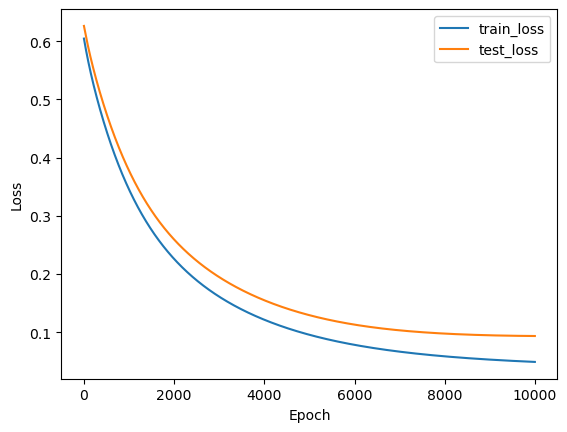

In [78]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [79]:
sum(1 for i in range(N_train) if Y_train[i]==1. and pred_train[i]<0.5)
+sum(1 for i in range(N_train) if Y_train[i]==0. and pred_train[i]>=0.5)

120

In [80]:
sum(1 for i in range(N_test) if Y_test[i]==1. and pred_test[i]<0.5)
+sum(1 for i in range(N_test) if Y_test[i]==0. and pred_test[i]>=0.5)

3

$120$ data points are misclassified in training dataset while $3$ points from the testing dataset are mis-predicted. The over-all model performance is worse but we get a simpler model. Mabye the error comes from the noise or outliers.

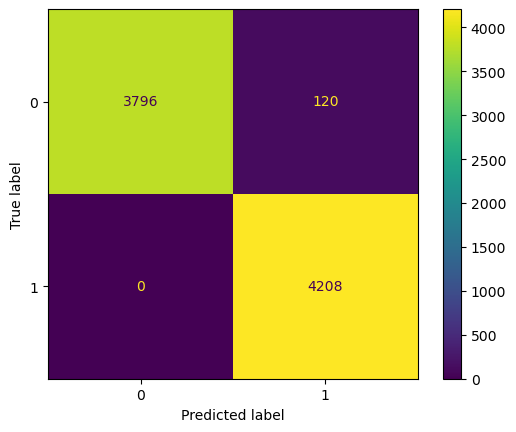

In [81]:
pred_train_01 = torch.where(pred_train>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_train, pred_train_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

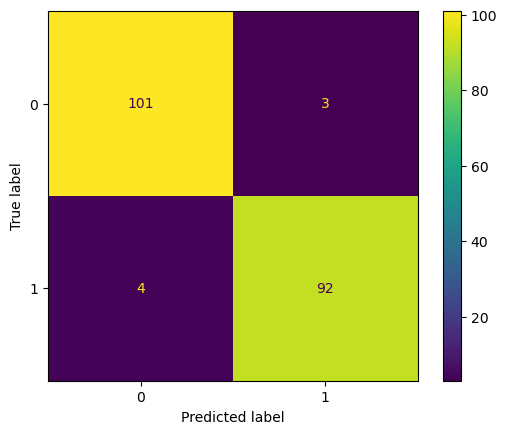

In [82]:
pred_test_01 = torch.where(pred_test>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_test, pred_test_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

### 5)
The second classifier should be linear but does not need to use any feature selection, but you may
still choose to use $l_2$ regularization. Rather than report the support provide a scatter plot where the
x-coordinate of each point is the coefficient for a feature using the first classifier (noting that some of the coefficients for the first classifier will be exactly zero if there was feature selection) and the
y-coordinate of the point is the coefficient value for the second classifier.

In [83]:
model = LogisticRegression(input_size)
bce=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())
history={'train_loss':[],'test_loss':[]}
for epoch in trange(10000):
    pred_train = model(X_train)
    loss = bce(pred_train,Y_train)
    l2_norm = sum(torch.linalg.norm(p) for p in model.parameters())
    train_loss = loss + 0.001*l2_norm
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    history['train_loss'].append(train_loss.item())
    
    pred_test = model(X_test)
    test_loss = bce(pred_test,Y_test)
    history['test_loss'].append(test_loss.item())

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 807.61it/s]


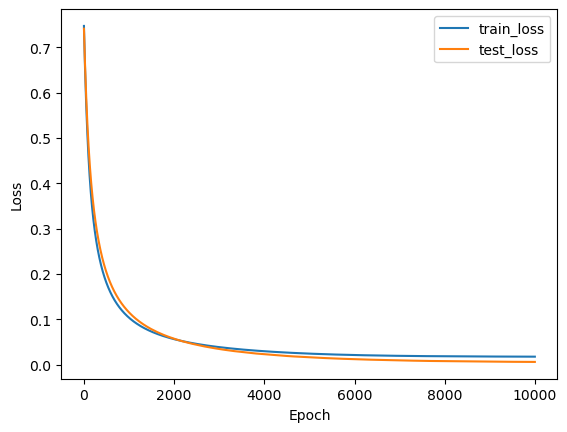

In [84]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.2883, -0.5825, -0.0197,  0.0242,  0.7102,  0.0383,  0.7779, -0.8554,
         -0.2719,  0.1484, -1.2209,  0.8837,  0.0812, -0.1556,  0.4846, -1.1845,
          0.6141,  0.6141, -0.5934,  0.2888,  0.6153, -0.5960,  3.6723, -4.6390,
         -2.8982,  3.6585, -0.4932,  3.1645, -3.0577, -1.1555, -1.1554,  0.2603,
         -0.3795, -1.1228,  0.9900,  2.0965, -2.2925, -1.7386,  0.7427,  0.0990,
         -0.0761,  0.6643,  0.7466,  0.1955,  0.4883, -0.8116,  0.3482,  0.3158,
         -0.1052, -0.3024,  0.1981,  0.5071, -1.3504,  1.0994, -0.1487,  1.3737,
         -0.4899,  0.3607, -1.2850, -0.5437, -0.4932,  0.6590,  0.6716, -0.3360,
          0.6012, -0.2688,  0.0624, -0.4335, -0.4341, -0.4931,  0.5976,  0.6333,
          0.3796,  0.6003, -0.2902, -0.1370, -0.9232, -0.0981,  0.2886,  0.2887,
         -0.2800, -0.4335, -0.4934, -0.1893,  0.6456, -0.1980,  3.4567, -1.5002,
         -0.4931, -0.1397,  0.1809, -2.0256,  1.9953,  2.1243,  0.1809, -5.1305,
     

In [86]:
w2 = model.linear.weight.data.view(-1)
w2

tensor([-0.2883, -0.5825, -0.0197,  0.0242,  0.7102,  0.0383,  0.7779, -0.8554,
        -0.2719,  0.1484, -1.2209,  0.8837,  0.0812, -0.1556,  0.4846, -1.1845,
         0.6141,  0.6141, -0.5934,  0.2888,  0.6153, -0.5960,  3.6723, -4.6390,
        -2.8982,  3.6585, -0.4932,  3.1645, -3.0577, -1.1555, -1.1554,  0.2603,
        -0.3795, -1.1228,  0.9900,  2.0965, -2.2925, -1.7386,  0.7427,  0.0990,
        -0.0761,  0.6643,  0.7466,  0.1955,  0.4883, -0.8116,  0.3482,  0.3158,
        -0.1052, -0.3024,  0.1981,  0.5071, -1.3504,  1.0994, -0.1487,  1.3737,
        -0.4899,  0.3607, -1.2850, -0.5437, -0.4932,  0.6590,  0.6716, -0.3360,
         0.6012, -0.2688,  0.0624, -0.4335, -0.4341, -0.4931,  0.5976,  0.6333,
         0.3796,  0.6003, -0.2902, -0.1370, -0.9232, -0.0981,  0.2886,  0.2887,
        -0.2800, -0.4335, -0.4934, -0.1893,  0.6456, -0.1980,  3.4567, -1.5002,
        -0.4931, -0.1397,  0.1809, -2.0256,  1.9953,  2.1243,  0.1809, -5.1305,
         1.8277,  0.1597,  0.1810,  0.17

Plot weights for $l_1$ and $l_2$ regularization.

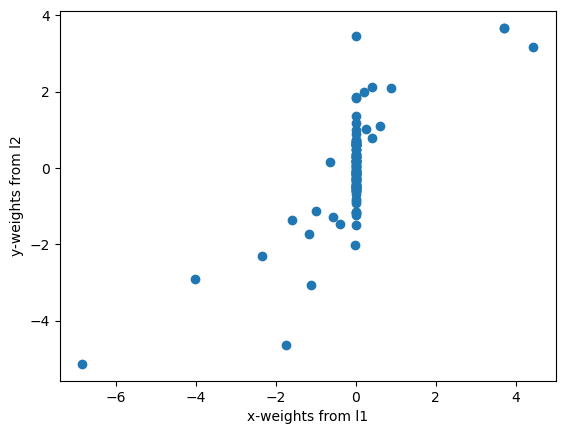

In [87]:
plt.scatter(w,w2)
plt.xlabel("x-weights from l1")
plt.ylabel("y-weights from l2")
plt.show()

Clearly see, most weights in $l_2$ are located in $[-2,2]$ while most weights in $l_1$ are concentrated around $0$.

### 6)
The third classifier you are free to choose, but it should be non-linear (k-nearest neighbor, kernel
support vector machine, random forest with or without gradient boosting, etc.). State the method
(model and loss), any regularization, and any other design choices. Describe how you would explain
the prediction mechanism of this non-linear model.

Since there are $8124$ samples in the training dataset, it's not a good idea using SVM or $k$-NN. We choose a neural network with one hidden layer. The activation function in hidden layer is ReLu and that in output layer is the sigmoid function. We still use cross entropy as the loss to train the model. Also, we will penalize more if the model predict poisonous mushrooms as edible, as what we have done in 1).

In [88]:
class Non_Linear(nn.Module):
    def __init__(self, input_size):
        super(Non_Linear, self).__init__()
        self.fc1 = nn.Linear(input_size,56)
        self.fc2 = nn.Linear(56,1)
        
    def forward(self,input):
        output = nn.functional.relu(self.fc1(input))
        output = torch.sigmoid(self.fc2(output))
        return output

In [89]:
model = Non_Linear(input_size)
print(model)

Non_Linear(
  (fc1): Linear(in_features=112, out_features=56, bias=True)
  (fc2): Linear(in_features=56, out_features=1, bias=True)
)


In [90]:
bce=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())

In [91]:
history={'train_loss':[],'test_loss':[]}
for epoch in trange(5000):
    pred0_train = model(X0_train)
    loss0 = bce(pred0_train,Y0_train)
    pred1_train = model(X1_train)
    loss1 = bce(pred1_train,Y1_train)
    train_loss = 1.5*loss0 + loss1
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    history['train_loss'].append(train_loss.item())
    
    pred_test = model(X_test)
    test_loss = bce(pred_test,Y_test)
    history['test_loss'].append(test_loss.item())

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 301.78it/s]


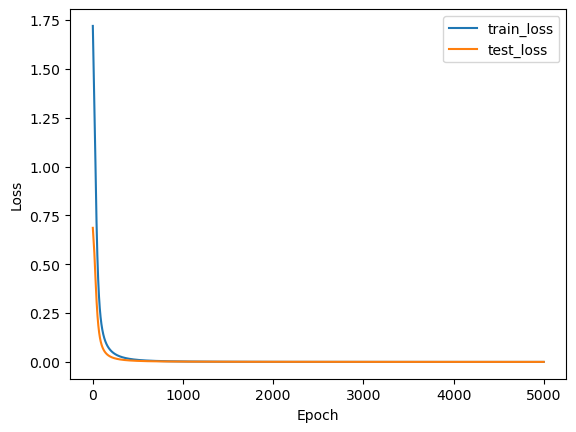

In [92]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
sum(1 for i in range(N_train) if Y_train[i]==1. and pred_train[i]<0.5)
+sum(1 for i in range(N_train) if Y_train[i]==0. and pred_train[i]>=0.5)

0

In [94]:
sum(1 for i in range(N_test) if Y_test[i]==1. and pred_test[i]<0.5)
+sum(1 for i in range(N_test) if Y_test[i]==0. and pred_test[i]>=0.5)

0

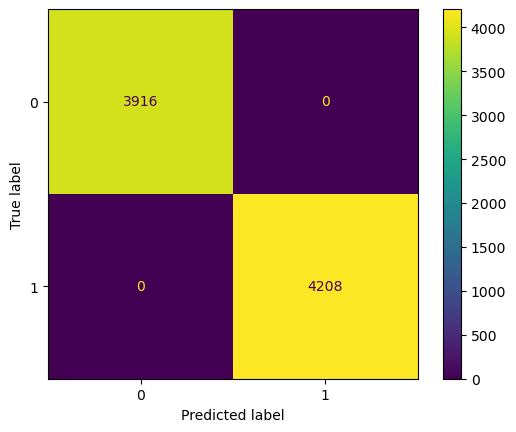

In [95]:
pred_train_01 = torch.where(pred_train>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_train, pred_train_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

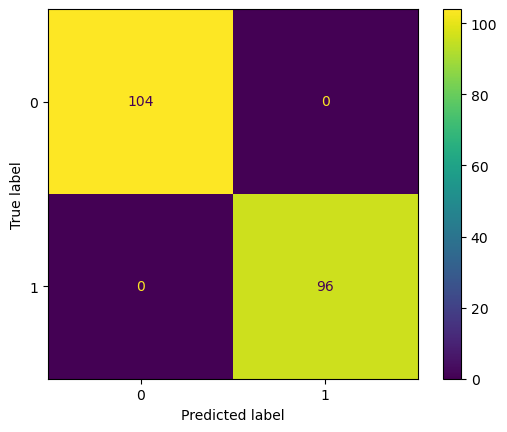

In [96]:
pred_test_01 = torch.where(pred_test>=0.5,1.0,0.0)
cf_matrix = confusion_matrix(Y_test, pred_test_01.detach())
cm_display = ConfusionMatrixDisplay(cf_matrix).plot()

The model achieves zero error both in training and testing dataset. The penalizing weight is larger than that in 1) and less training epoch is required to achieve zero error performance. This implies this non-linear model converges faster than logistic regression or weighted logistic regression, which also can be seen via observing the loss curve over epochs.

### 7)
For all three classifiers select the hyper-parameters using a valid experimental design—You should
not use any information from the test set. For instance, you could perform 5-fold cross-validation
on the training set to select the regularization parameter, or you could use a fixed validation set. In
either case you can use a weighted validation metric of your choice based on your answer to (1)
above.

We do it for $l_1$ regularization classifer. The other two cases are similar. We consider the hyper-parameter set $\Lambda=\{0.1,0.01,0.001,0.0001\}$ and selet the best one.

In [97]:
H = [0.1,0.01,0.001,0.0001]

Split the training dataset into training and validation dataset in ratio $8:2$.

In [98]:
split_point = int(0.8*N_train)
split_point

6499

In [99]:
X_train_ = X_train[0:split_point,:]
Y_train_ = Y_train[0:split_point,:]
X_valid_ = X_train[split_point:,:]
Y_valid_ = Y_train[split_point:,:]

In [100]:
print(X_train_.shape)
print(Y_train_.shape)
print(X_valid_.shape)
print(Y_valid_.shape)

torch.Size([6499, 112])
torch.Size([6499, 1])
torch.Size([1625, 112])
torch.Size([1625, 1])


In [101]:
def train_l1():
    for h in H:
        model = LogisticRegression(input_size)
        bce=nn.BCELoss()
        optimizer=torch.optim.Adam(model.parameters())
        history={'train_loss':[],'valid_loss':[]}
        
        for epoch in trange(10000):
            pred_train = model(X_train_)
            loss = bce(pred_train,Y_train_)
            l1_norm = sum(torch.abs(p).sum() for p in model.parameters())
            train_loss = loss + h*l1_norm
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            history['train_loss'].append(train_loss.item())
            
            pred_valid = model(X_valid_)
            valid_loss = bce(pred_valid,Y_valid_)
            history['valid_loss'].append(valid_loss.item())
        
        print("Hyper-parameter: ",h)
        plt.plot(history['train_loss'], label='train_loss')
        plt.plot(history['valid_loss'], label='valid_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        print("model performance on test dataset")
        pred_test = model(X_test)
        pred_test_01 = torch.where(pred_test>=0.5,1.0,0.0)
        cf_matrix = confusion_matrix(Y_test, pred_test_01.detach())
        cm_display = ConfusionMatrixDisplay(cf_matrix).plot()
        plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 826.73it/s]


Hyper-parameter:  0.1


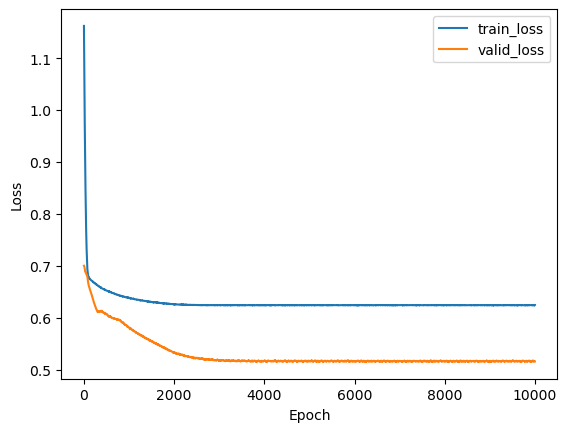

model performance on test dataset


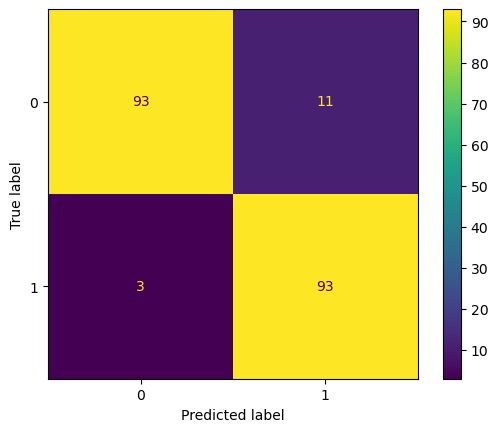

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 821.58it/s]


Hyper-parameter:  0.01


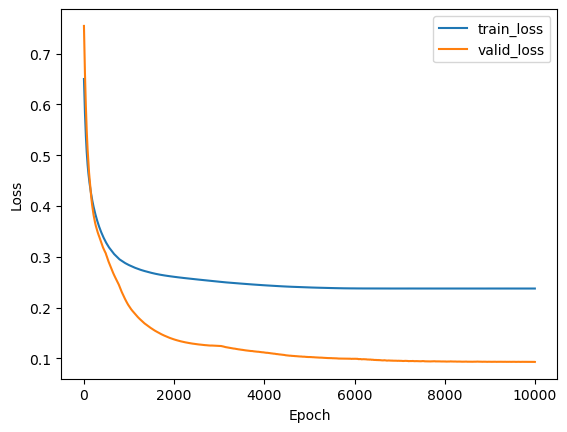

model performance on test dataset


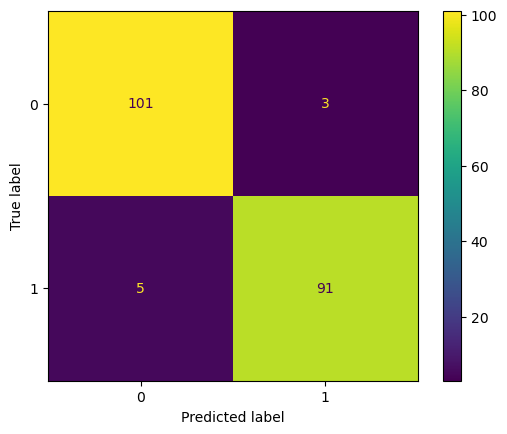

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 834.76it/s]


Hyper-parameter:  0.001


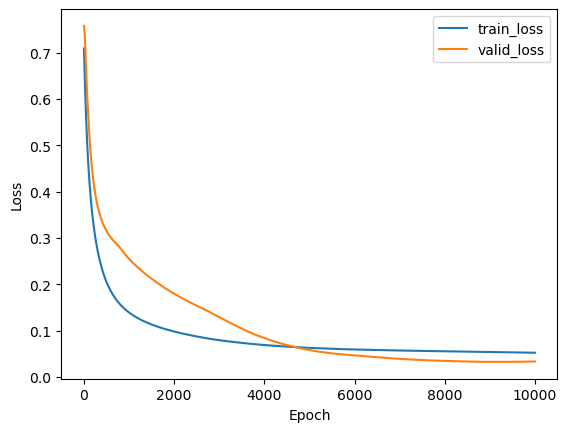

model performance on test dataset


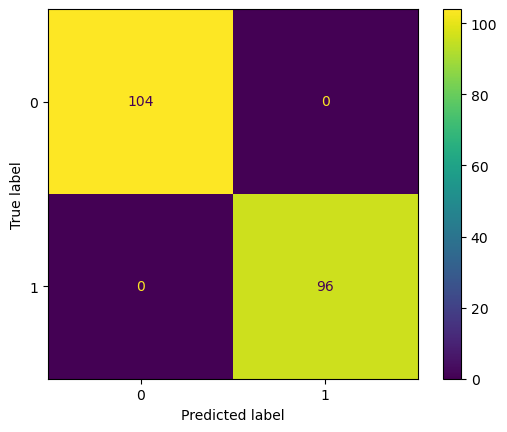

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 831.30it/s]


Hyper-parameter:  0.0001


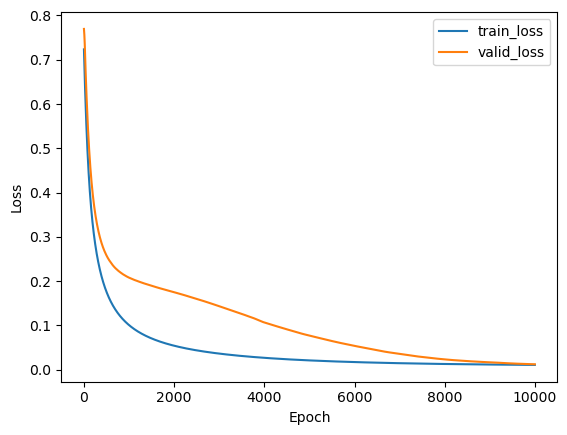

model performance on test dataset


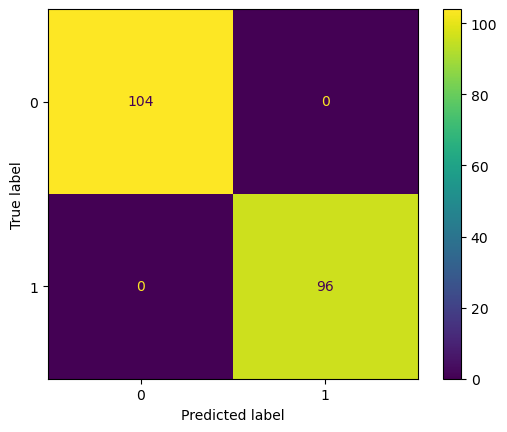

In [102]:
train_l1()

To achieve better performance, we should choose smaller hyper-parameter as the logistic regression withought regularization can achieve zero error. But too small hyper-parameter will fail to select features (do not shrink model weights). Via observing the confusion matrix for each case, the hyper-parameter $\lambda=0.001$ is a right choice.

### 8) 
To evalute your three final classifiers (linear with feature selection, linear without feature selection,
and non-linear) report the correspondence of each predictions on the test set using a confusion
matrix (results will be three 2-by-2 matrices)

In precediing problems, model performance is displayed via confusion matrix.

### 9)
 Write a short discussion of the results, your insights, and the limitations (5–10 sentences)

Using logistic regression classifier, we can realize zero-error performance on training and testing dataset. Adding $l_2$ regulariztion, the model have the same performance. The $l_1$ regularization slightly decreases model performance but get a simpler model, which is more robust to outliers. The non-linear classifier with one hidden layer can achieve zero classification error in training and testing dataset with less training epochs. Also, even a larger weight of training loss is used to penalize poisonous mushrooms and no performance decreases. 

### 10)
Provide your code in a readable format.